# Loading Datasets

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, make_scorer # maybe can remove
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
merged_data = pd.read_csv('credit_card_prediction_cleaned_3.csv')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36455 entries, 0 to 36454
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                36455 non-null  int64  
 1   owns_car              36455 non-null  int64  
 2   owns_property         36455 non-null  int64  
 3   n_children            36455 non-null  int64  
 4   annual_income         36455 non-null  float64
 5   income_type           36455 non-null  object 
 6   education_type        36455 non-null  object 
 7   marital_status        36455 non-null  object 
 8   housing_type          36455 non-null  object 
 9   has_email             36455 non-null  int64  
 10  occupation            36455 non-null  object 
 11  n_fam_members         36455 non-null  float64
 12  age                   36455 non-null  float64
 13  label                 36455 non-null  int64  
 14  employment_age_ratio  36455 non-null  float64
 15  single_parent      

#Splitting train and test datasets

In [ ]:
X = merged_data.drop(['label'], axis=1)
y = merged_data['label']

#split into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# transform
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object','category']).columns
print(numeric_features)
print(categorical_features)

# Create preprocessing transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Index(['gender', 'owns_car', 'owns_property', 'n_children', 'annual_income',
       'has_email', 'n_fam_members', 'age', 'employment_age_ratio',
       'single_parent', 'communication_score'],
      dtype='object')
Index(['income_type', 'education_type', 'marital_status', 'housing_type',
       'occupation'],
      dtype='object')


#Model Optimisation

In [ ]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)
# Transform the test data using the same preprocessor
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Get feature names after transformation
numeric_features_new = numeric_features.tolist()
# Get categorical feature names after one-hot encoding
categorical_features_new = []
for i, feature in enumerate(categorical_features):
    # Get the categories for each categorical feature (excluding the dropped one)
    categories = preprocessor.named_transformers_['cat'].categories_[i][1:]
    categorical_features_new.extend([f"{feature}_{cat}" for cat in categories])

# Combine all feature names
feature_names = numeric_features_new + categorical_features_new
print(feature_names)
# Convert transformed arrays to DataFrames with proper column names
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index
)
X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=feature_names,
    index=X_test.index
)

['gender', 'owns_car', 'owns_property', 'n_children', 'annual_income', 'has_email', 'n_fam_members', 'age', 'employment_age_ratio', 'single_parent', 'communication_score', 'income_type_Pensioner', 'income_type_State servant', 'income_type_Student', 'income_type_Working', 'education_type_Higher education', 'education_type_Incomplete higher', 'education_type_Lower secondary', 'education_type_Secondary / secondary special', 'marital_status_Married', 'marital_status_Separated', 'marital_status_Single / not married', 'marital_status_Widow', 'housing_type_House / apartment', 'housing_type_Municipal apartment', 'housing_type_Office apartment', 'housing_type_Rented apartment', 'housing_type_With parents', 'occupation_Cleaning staff', 'occupation_Cooking staff', 'occupation_Core staff', 'occupation_Drivers', 'occupation_HR staff', 'occupation_High skill tech staff', 'occupation_IT staff', 'occupation_Laborers', 'occupation_Low-skill Laborers', 'occupation_Managers', 'occupation_Medicine staff',

Using SMOTE

In [ ]:
# Apply SMOTE to the training data
ros = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_transformed, y_train)

# Print some information about the transformation
print("Original training set shape:", X_train.shape)
print("Transformed training set shape:", X_train_transformed.shape)
print("Resampled training set shape:", X_train_resampled.shape)
print("Original test set shape:", X_test.shape)
print("Transformed test set shape:", X_test_transformed.shape)

Original training set shape: (29164, 16)
Transformed training set shape: (29164, 47)
Resampled training set shape: (58052, 47)
Original test set shape: (7291, 16)
Transformed test set shape: (7291, 47)


1) Original Decision Tree

Decision Tree:


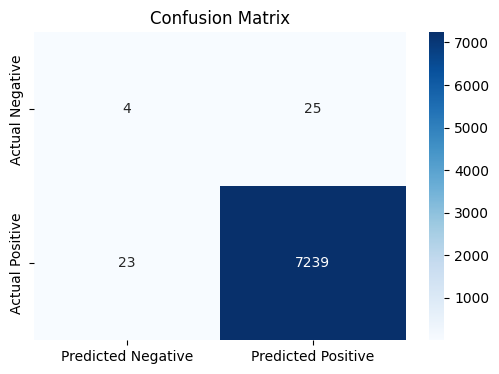

              precision    recall  f1-score   support

           0       0.15      0.14      0.14        29
           1       1.00      1.00      1.00      7262

    accuracy                           0.99      7291
   macro avg       0.57      0.57      0.57      7291
weighted avg       0.99      0.99      0.99      7291

Specificity: 0.13793103448275862
Matthews's Correlation Coefficient: 0.13964673064224417
AUC PRC Score: 0.9965566728310461


In [ ]:
# Train Decision Tree on original data
dt_original = DecisionTreeClassifier(random_state=42)
dt_original.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate
y_pred_original = dt_original.predict(X_test_transformed)
y_prob_original = dt_original.predict_proba(X_test_transformed)[:, 1]

print("Decision Tree:")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_original).ravel()

results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                          columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(6, 4))
sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred_original))
specificity = tn / (tn + fp)
print("Specificity:", specificity)
mc = matthews_corrcoef(y_test, y_pred_original)
print("Matthews's Correlation Coefficient:", mc)
print("AUC PRC Score:", average_precision_score(y_test, y_pred_original))

2) Random Forest (reduce overfitting)

Random Forest:


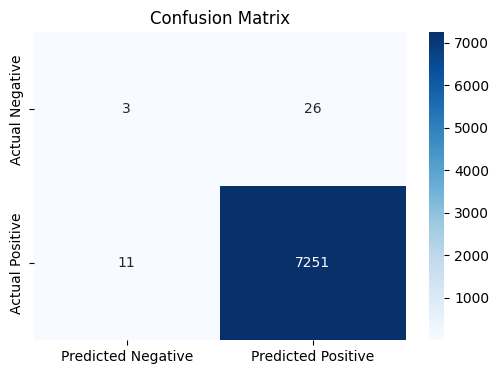

              precision    recall  f1-score   support

           0       0.21      0.10      0.14        29
           1       1.00      1.00      1.00      7262

    accuracy                           0.99      7291
   macro avg       0.61      0.55      0.57      7291
weighted avg       0.99      0.99      0.99      7291

Specificity: 0.10344827586206896
Matthews's Correlation Coefficient: 0.1465561439616959
AUC PRC Score: 0.9964264862093466


In [ ]:
# Train Random Forest on original data
rf_original = RandomForestClassifier(random_state=42) # TO OPTIMISE
rf_original.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate
y_pred_original = rf_original.predict(X_test_transformed)
y_prob_original = rf_original.predict_proba(X_test_transformed)[:, 1]

print("Random Forest:")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_original).ravel()

results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                          columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(6, 4))
sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred_original))
specificity = tn / (tn + fp)
print("Specificity:", specificity)
mc = matthews_corrcoef(y_test, y_pred_original)
print("Matthews's Correlation Coefficient:", mc)
print("AUC PRC Score:", average_precision_score(y_test, y_pred_original))

3) Adaboost

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adaboost:


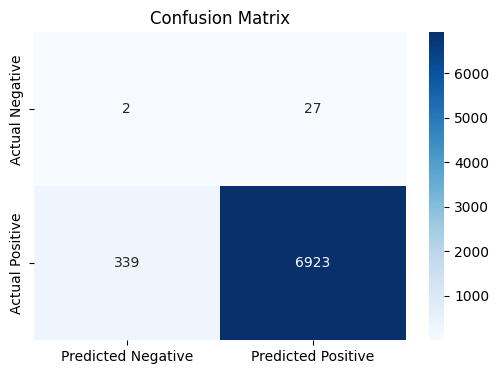

              precision    recall  f1-score   support

           0       0.01      0.07      0.01        29
           1       1.00      0.95      0.97      7262

    accuracy                           0.95      7291
   macro avg       0.50      0.51      0.49      7291
weighted avg       0.99      0.95      0.97      7291

Specificity: 0.06896551724137931
Matthews's Correlation Coefficient: 0.006642840750544599
AUC PRC Score: 0.9961107845466519


In [ ]:
# Train Adaboost on original data
ada_original = AdaBoostClassifier(random_state=42, algorithm='SAMME.R')
ada_original.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate
y_pred_original = ada_original.predict(X_test_transformed)
y_prob_original = ada_original.predict_proba(X_test_transformed)[:, 1]

print("Adaboost:")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_original).ravel()

results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                          columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(6, 4))
sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred_original))
specificity = tn / (tn + fp)
print("Specificity:", specificity)
mc = matthews_corrcoef(y_test, y_pred_original)
print("Matthews's Correlation Coefficient:", mc)
print("AUC PRC Score:", average_precision_score(y_test, y_pred_original))

4) Gradient Boosting

Gradient Boosting:


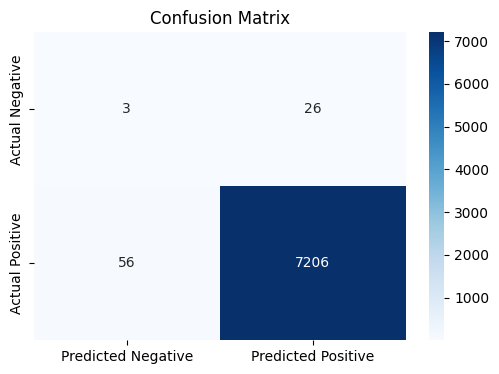

              precision    recall  f1-score   support

           0       0.05      0.10      0.07        29
           1       1.00      0.99      0.99      7262

    accuracy                           0.99      7291
   macro avg       0.52      0.55      0.53      7291
weighted avg       0.99      0.99      0.99      7291

Specificity: 0.10344827586206896
Matthews's Correlation Coefficient: 0.06725913452505215
AUC PRC Score: 0.9964019186293712


In [ ]:
# Train Gradient Boosting on original data
gb_original = GradientBoostingClassifier(random_state=42) # TO OPTIMISE
gb_original.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate
y_pred_original = gb_original.predict(X_test_transformed)
y_prob_original = gb_original.predict_proba(X_test_transformed)[:, 1]

print("Gradient Boosting:")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_original).ravel()

results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                          columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(6, 4))
sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred_original))
specificity = tn / (tn + fp)
print("Specificity:", specificity)
mc = matthews_corrcoef(y_test, y_pred_original)
print("Matthews's Correlation Coefficient:", mc)
print("AUC PRC Score:", average_precision_score(y_test, y_pred_original))

#HYPERPARAMETER TUNING: By GridSearchCV

1) OG DT Model

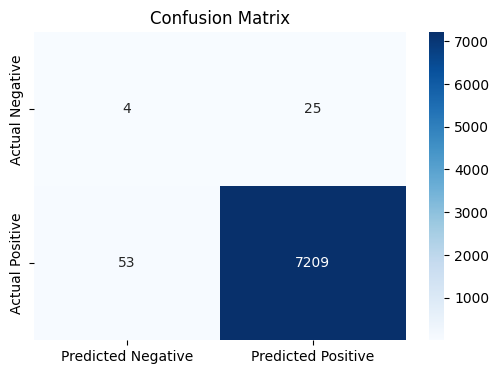

              precision    recall  f1-score   support

           0       0.07      0.14      0.09        29
           1       1.00      0.99      0.99      7262

    accuracy                           0.99      7291
   macro avg       0.53      0.57      0.54      7291
weighted avg       0.99      0.99      0.99      7291

Specificity: 0.13793103448275862
Matthews's Correlation Coefficient: 0.09335822277171767
AUC PRC Score: 0.9965402905152514


In [ ]:
def gridsearchCV_dt(preprocessor, model):
    pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('oversampler', SMOTE(sampling_strategy='minority', random_state=42)),  # Use SMOTE for oversampling
      ('classifier', model)])
    param_grid = {
        'classifier__max_depth': [1,3,5,9,15,20], # default=3
        'classifier__min_samples_split': [2,3,4,5,10], # default=2
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise') # evaluate using f1 score
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
   # print('best_model:',best_model)
    #best_params = grid_search.best_params_
    #print('best_params:',best_params)
    #best_score = grid_search.best_score_
    #print('best_score:',best_score)
    y_pred = best_model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                              columns=['Predicted Negative', 'Predicted Positive'],
                              index=['Actual Negative', 'Actual Positive'])

    plt.figure(figsize=(6, 4))
    sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_test, y_pred))
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)
    mc = matthews_corrcoef(y_test, y_pred)
    print("Matthews's Correlation Coefficient:", mc)
    print("AUC PRC Score:", average_precision_score(y_test, y_pred))
    return

gridsearchCV_dt(preprocessor, DecisionTreeClassifier(random_state=42))

2) Random Forest Model

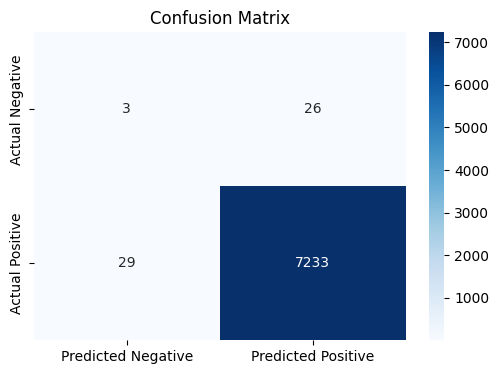

              precision    recall  f1-score   support

           0       0.09      0.10      0.10        29
           1       1.00      1.00      1.00      7262

    accuracy                           0.99      7291
   macro avg       0.55      0.55      0.55      7291
weighted avg       0.99      0.99      0.99      7291

Specificity: 0.10344827586206896
Matthews's Correlation Coefficient: 0.09469779267749558
AUC PRC Score: 0.9964166590589325


In [ ]:
# for DT model 2
def gridsearchCV_dt_ensemble(preprocessor, model):
    pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('oversampler', SMOTE(sampling_strategy='minority', random_state=42)),  # Use SMOTE for oversampling
      ('classifier', model)])
    param_grid = {
        'classifier__max_depth': [1,3,5,9,15,20], # default=3
        'classifier__min_samples_split': [2,3,4,5,10], # default=2
        'classifier__n_estimators': [5,10,20,30] # default=10
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
  #  print('best_model:',best_model)
    #best_params = grid_search.best_params_
    #print('best_params:',best_params)
    #best_score = grid_search.best_score_
    #print('best_score:',best_score)
    y_pred = best_model.predict(X_test)
    #print(classification_report(y_test, y_pred))
    #print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_original):.4f}\n")
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                              columns=['Predicted Negative', 'Predicted Positive'],
                              index=['Actual Negative', 'Actual Positive'])

    plt.figure(figsize=(6, 4))
    sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_test, y_pred))
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)
    mc = matthews_corrcoef(y_test, y_pred)
    print("Matthews's Correlation Coefficient:", mc)
    print("AUC PRC Score:", average_precision_score(y_test, y_pred))
    return
# model 2
gridsearchCV_dt_ensemble(preprocessor, RandomForestClassifier(random_state=42))

3) AdaBoost

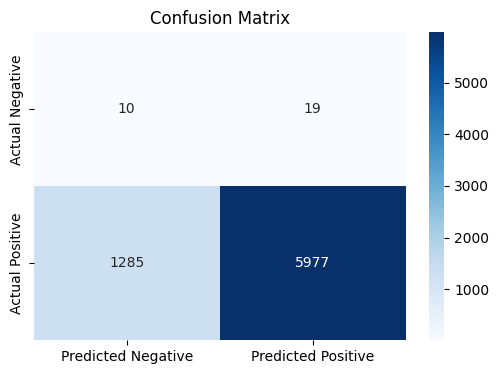

              precision    recall  f1-score   support

           0       0.01      0.34      0.02        29
           1       1.00      0.82      0.90      7262

    accuracy                           0.82      7291
   macro avg       0.50      0.58      0.46      7291
weighted avg       0.99      0.82      0.90      7291

Specificity: 0.3448275862068966
Matthews's Correlation Coefficient: 0.027647637336384947
AUC PRC Score: 0.9966881177269229


In [ ]:
# for DT model 3 n 4

def gridsearchCV_dt_booster(preprocessor, model):
    pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('oversampler', SMOTE(sampling_strategy='minority', random_state=42)),  # Use SMOTE for oversampling
      ('classifier', model)])
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1, 1.0],
        'classifier__n_estimators': [5,10,20,30] # default=10
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
  #  print('best_model:',best_model)
    #best_params = grid_search.best_params_
    #print('best_params:',best_params)
    #best_score = grid_search.best_score_
    #print('best_score:',best_score)
    y_pred = best_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results_df = pd.DataFrame([[tn, fp], [fn, tp]],
                              columns=['Predicted Negative', 'Predicted Positive'],
                              index=['Actual Negative', 'Actual Positive'])

    plt.figure(figsize=(6, 4))
    sb.heatmap(results_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_test, y_pred))
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)
    mc = matthews_corrcoef(y_test, y_pred)
    print("Matthews's Correlation Coefficient:", mc)
    print("AUC PRC Score:", average_precision_score(y_test, y_pred))
    return

# model 3
gridsearchCV_dt_booster(preprocessor, AdaBoostClassifier(random_state=42, algorithm='SAMME'))

4) Gradient Boost

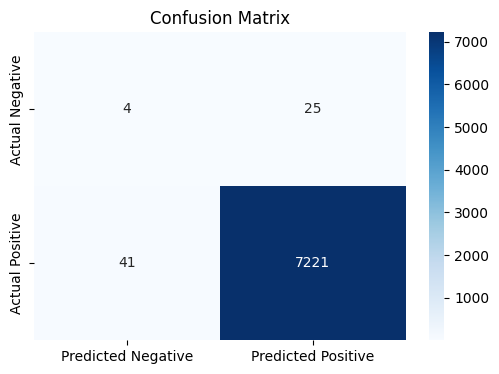

              precision    recall  f1-score   support

           0       0.09      0.14      0.11        29
           1       1.00      0.99      1.00      7262

    accuracy                           0.99      7291
   macro avg       0.54      0.57      0.55      7291
weighted avg       0.99      0.99      0.99      7291

Specificity: 0.13793103448275862
Matthews's Correlation Coefficient: 0.1063121693865125
AUC PRC Score: 0.9965468433927462


In [ ]:
# model 4
gridsearchCV_dt_booster(preprocessor, GradientBoostingClassifier(random_state=42))